In [15]:
from fredapi import Fred
import pandas as pd

fred = Fred(api_key="d56526f64808d2daa6f74c5775edfb03")

tickers = {
    "1M": "GS1M",
    "3M": "GS3M",
    "6M": "GS6M",
    "1Y": "GS1",
    "2Y": "GS2",
    "3Y": "GS3",
    "5Y": "GS5",
    "7Y": "GS7",
    "10Y": "GS10",
    "20Y": "GS20",
    "30Y": "GS30"
}

# Build the DataFrame
df = pd.DataFrame()
for label, code in tickers.items():
    df[label] = fred.get_series(code)

df = df.dropna().sort_index()
df.head()

,1M,3M,6M,1Y,2Y,3Y,5Y,7Y,10Y,20Y,30Y
2001-07-01,3.67,3.59,3.56,3.62,4.04,4.31,4.76,5.06,5.24,5.75,5.61
2001-08-01,3.53,3.44,3.39,3.47,3.76,4.04,4.57,4.84,4.97,5.58,5.48
2001-09-01,2.68,2.69,2.71,2.82,3.12,3.45,4.12,4.51,4.73,5.53,5.48
2001-10-01,2.27,2.20,2.17,2.33,2.73,3.14,3.91,4.31,4.57,5.34,5.32
2001-11-01,1.99,1.91,1.92,2.18,2.78,3.22,3.97,4.42,4.65,5.33,5.12


In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Fill any gaps
df = df.interpolate().dropna()

# Standardize
scaler = StandardScaler()
X = scaler.fit_transform(df)

# Initialize model
pca = PCA()
pca.fit(X)

explained_variance = pca.explained_variance_ratio_
components = pca.components_  # shape: (n_components, n_features)
scores = pca.transform(X)     # shape: (n_samples, n_components)
components

array([[ 2.98690296e-01,  3.00571567e-01,  3.03446864e-01,
         3.08739267e-01,  3.18088187e-01,  3.22928676e-01,
         3.23204463e-01,  3.14587173e-01,  2.98833672e-01,
         2.68715562e-01,  2.50283938e-01],
       [-3.03437227e-01, -3.06421183e-01, -2.97804002e-01,
        -2.66278865e-01, -1.76720398e-01, -8.75217013e-02,
         8.76888075e-02,  2.12277649e-01,  3.27120490e-01,
         4.50644305e-01,  5.02703562e-01],
       [-4.44555628e-01, -3.31368977e-01, -1.74512618e-01,
         1.67567721e-02,  2.87612688e-01,  4.10345414e-01,
         3.83798857e-01,  2.56752332e-01,  2.42409691e-02,
        -2.22581577e-01, -3.83889996e-01],
       [-5.07581585e-01, -1.29664146e-01,  2.51597710e-01,
         4.38923791e-01,  3.13745180e-01,  6.49246519e-02,
        -2.89660857e-01, -3.93185520e-01, -1.47229028e-01,
         2.62072845e-01,  1.95152670e-01],
       [-1.07013166e-01,  5.86154187e-02,  1.89636146e-01,
         7.52604663e-02, -2.09931902e-01, -2.15070185e-01,
  

## Plot the principle components with their explained variance

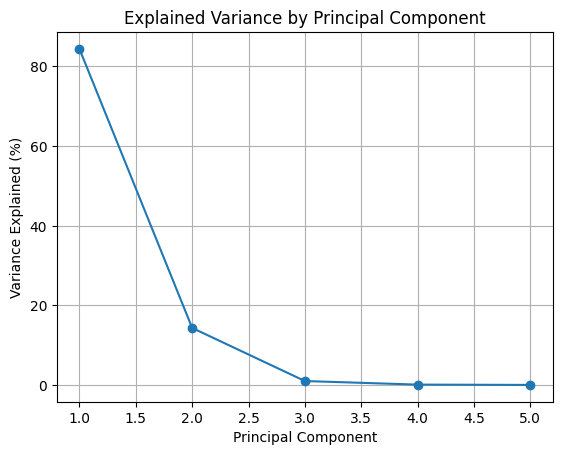

In [17]:
import matplotlib.pyplot as plt

# Only use first 6 principal components
plt.plot(range(1, 6), explained_variance[:5] * 100, marker='o')
plt.title("Explained Variance by Principal Component")
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained (%)")
plt.grid(True)
plt.show()

## Principal Component Loadings Plot

This plot shows the **loadings** of the first three principal components (PCs) across different bond maturities. Each PC represents a common pattern of movement in the yield curve:

- **PC1 – Level**: Affects all maturities roughly equally, representing an overall shift in interest rates (up or down).
- **PC2 – Slope**: Opposite effects on short vs. long maturities, capturing steepening or flattening of the yield curve.
- **PC3 – Curvature**: Emphasizes the middle maturities, showing changes in the curve’s shape (hump or dip in the middle).

**X-axis** = Bond maturities (in years)  
**Y-axis** = Loading values (how much each maturity contributes to that PC)

This visualization helps interpret what each PC means in terms of yield curve dynamics and is key to understanding how PCA decomposes complex interest rate movements into simple, interpretable components.

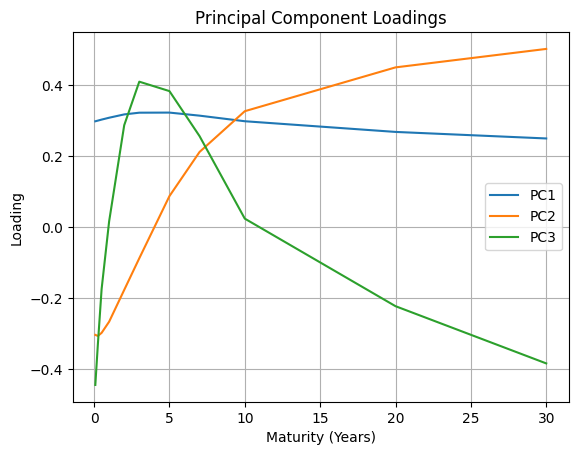

In [6]:
maturity_labels = df.columns
maturity_nums = [1/12, 0.25, 0.5, 1, 2, 3, 5, 7, 10, 20, 30]  # In years

for i in range(3):
    plt.plot(maturity_nums, components[i], label=f"PC{i+1}")

plt.legend()
plt.title("Principal Component Loadings")
plt.xlabel("Maturity (Years)")
plt.ylabel("Loading")
plt.grid(True)
plt.show()

## Plot PC Scores Over Time

This plot shows the **scores** for the first three principal components (PC1, PC2, and PC3) over time. Each score represents how much that specific principal component (Level, Slope, Curvature) contributed to the yield curve’s shape on a given day.

- **PC1 Score**: Represents the **level** of interest rates on that day. High scores indicate a general increase in rates.
- **PC2 Score**: Represents the **slope** of the yield curve. Positive values indicate a steeper curve, while negative values show a flattening.
- **PC3 Score**: Represents the **curvature** of the yield curve. Positive values indicate a U-shaped curve (higher at middle maturities), and negative values show a more inverted shape.

This plot helps us understand **how the yield curve changes** over time and how much each of the three dominant components (Level, Slope, Curvature) contributed to those changes.

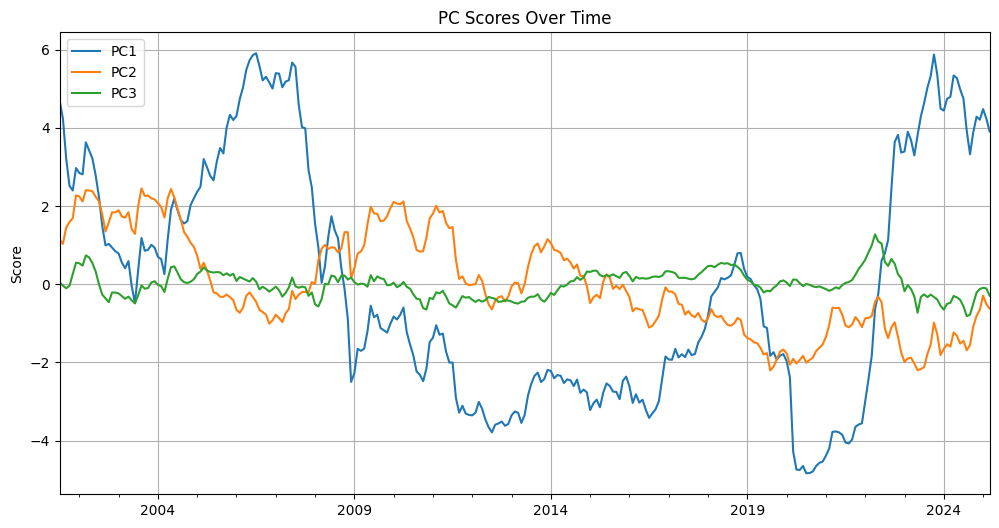

In [7]:
scores_df = pd.DataFrame(scores[:, :3], columns=['PC1', 'PC2', 'PC3'], index=df.index)

scores_df.plot(title="PC Scores Over Time", figsize=(12, 6))
plt.grid(True)
plt.ylabel("Score")
plt.show()